# Connect Four AI

Đây là một trò chơi Connect Four (4 nước thắng) được triển khai bằng Python, với AI sử dụng thuật toán Alpha-Beta Pruning.

## Ý tưởng thuật toán

### Minimax với Alpha-Beta Pruning

Thuật toán Minimax là một thuật toán quyết định trong trò chơi hai người. Alpha-Beta Pruning là một kỹ thuật tối ưu để giảm số lượng nút cần duyệt trong cây trò chơi.

Trong trò chơi Connect Four, mỗi nước đi có tối đa 7 lựa chọn (các cột). Độ sâu của cây trò chơi là giới hạn bởi số nước đi còn lại. Tuy nhiên, do giới hạn thời gian, chúng ta chỉ duyệt đến một độ sâu nhất định (ví dụ 5).

### Hàm đánh giá (Heuristic)

Hàm đánh giá được thiết kế để đánh giá trạng thái bàn cờ từ góc độ của người chơi. Nó xem xét các cửa sổ 4 ô liên tiếp (theo hàng ngang, dọc, chéo) và gán điểm dựa trên số lượng quân cờ của mỗi bên trong cửa sổ đó.

Các yếu tố được xem xét:
- Cửa sổ có 4 quân cùng màu: điểm rất cao (thắng).
- Cửa sổ có 3 quân cùng màu và 1 ô trống: điểm cao (đe dọa thắng).
- Cửa sổ có 2 quân cùng màu và 2 ô trống: điểm trung bình.
- Cửa sổ có 3 quân đối phương và 1 ô trống: điểm âm (nguy cơ thua).

Ngoài ra, trung tâm bàn cờ được ưu tiên vì khả năng tạo nhiều đường thắng.

## Cài đặt

### Các hàm chính

- `init_state()`: Khởi tạo bàn cờ và theo dõi các cột còn trống.
- `player(board)`: Xác định người chơi hiện tại.
- `actions(last_row_each_col)`: Trả về danh sách các cột có thể đánh.
- `result(board, last_row_each_col, action)`: Áp dụng nước đi và trả về trạng thái mới.
- `get_winner_exact(board)`: Kiểm tra xem có người thắng cuộc không.
- `heuristic(board)`: Hàm đánh giá trạng thái bàn cờ.
- `alphabeta_decision(board, last_row_each_col, depth)`: Quyết định nước đi tốt nhất cho AI.

### Chạy chương trình

Chương trình chính nằm trong `if __name__ == "__main__":` và cho phép người chơi đối đầu với AI.

## Cải tiến

- **Ordering moves**: Sắp xếp các nước đi theo thứ tự ưu tiên (ví dụ: các cột trung tâm trước) để tăng hiệu quả cắt tỉa.
- **Tăng độ sâu**: Có thể điều chỉnh độ sâu tìm kiếm để cân bằng giữa hiệu suất và sức mạnh của AI.
- **Heuristic tốt hơn**: Có thể cải thiện hàm đánh giá bằng cách xem xét thêm các yếu tố như đa đường tấn công, phòng thủ, v.v.

## Tham khảo

- [Wikipedia: Minimax](https://en.wikipedia.org/wiki/Minimax)
- [Wikipedia: Alpha–beta pruning](https://en.wikipedia.org/wiki/Alpha–beta_pruning)
- [Connect Four: Wikipedia](https://en.wikipedia.org/wiki/Connect_Four)

## Tác giả

[Dự án được thực hiện bởi - điền tên của bạn]

In [ ]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

In [12]:
import copy
import math
import random

# ---- constants ----
EMPTY = 0
PLAYER = 1    # human or "X"
BOT = -1      # ai or "O"
def init_state():
    matrix = [[EMPTY]*7 for _ in range(6)]
    # last_row_each_col[col] = next free row index in that column (from top=0 to bottom=5)
    last_row_each_col = [5,5,5,5,5,5,5]
    return matrix, last_row_each_col


In [13]:
def player(matrix):
    """
    Return who moves next on the board: PLAYER (1) or BOT (-1).
    We count non-empty cells; X (PLAYER) plays first (even count => PLAYER).
    """
    count = 0
    for row in matrix:
        for cell in row:
            if cell != EMPTY:
                count += 1
    # if count is even -> PLAYER's turn (PLAYER starts); if odd -> BOT's turn
    return PLAYER if (count % 2 == 0) else BOT


In [14]:
def actions(last_row_each_col):
    """
    Return list of available columns (0..6) where you can drop a piece.
    last_row_each_col gives the next free row index for each column, or -1 if full.
    """
    available = []
    for col, row_idx in enumerate(last_row_each_col):
        if row_idx >= 0:
            available.append(col)
    return available


In [1]:
# ---- result (apply action) ----
def result(matrix, last_row_each_col, action):
    """
    action: column integer
    returns new_matrix, new_last_row_each_col
    """
    col = action
    if last_row_each_col[col] < 0:
        raise ValueError("Column is full")

    new_matrix = [r[:] for r in matrix]
    new_last = last_row_each_col[:]  # shallow copy is fine (list of ints)

    row_to_place = new_last[col]
    cur_player = player(matrix)
    new_matrix[row_to_place][col] = cur_player
    new_last[col] -= 1  # next free row up one
    return new_matrix, new_last


In [17]:
# ---- winner detection (exact win) ----
def get_winner_exact(matrix):
    """
    Check for 4-in-a-row. Return PLAYER(1) or BOT(-1) if there's a winner, else None.
    """
    rows = len(matrix)
    cols = len(matrix[0])

    # horizontal
    for r in range(rows):
        for c in range(cols - 3):
            w = [matrix[r][c+i] for i in range(4)]
            if w.count(PLAYER) == 4:
                return PLAYER
            if w.count(BOT) == 4:
                return BOT

    # vertical
    for c in range(cols):
        for r in range(rows - 3):
            w = [matrix[r+i][c] for i in range(4)]
            if w.count(PLAYER) == 4:
                return PLAYER
            if w.count(BOT) == 4:
                return BOT

    # main diagonal (top-left to bottom-right)
    for r in range(rows - 3):
        for c in range(cols - 3):
            w = [matrix[r+i][c+i] for i in range(4)]
            if w.count(PLAYER) == 4:
                return PLAYER
            if w.count(BOT) == 4:
                return BOT

    # secondary diagonal (bottom-left to top-right)
    for r in range(3, rows):
        for c in range(cols - 3):
            w = [matrix[r-i][c+i] for i in range(4)]
            if w.count(PLAYER) == 4:
                return PLAYER
            if w.count(BOT) == 4:
                return BOT

    return None


In [18]:
# ---- heuristic (utility) ----
def evaluate_window(window, player_id):
    """
    window: list of 4 cells
    player_id: 1 or -1
    return score for this window from perspective of player_id
    """
    opponent = -player_id
    score = 0
    if window.count(player_id) == 4:
        score += 10000
    elif window.count(player_id) == 3 and window.count(EMPTY) == 1:
        score += 50
    elif window.count(player_id) == 2 and window.count(EMPTY) == 2:
        score += 5

    # block opponent 3-in-row
    if window.count(opponent) == 3 and window.count(EMPTY) == 1:
        score -= 300

    return score

def heuristic(matrix):
    """
    Sum heuristic over all windows (rows, cols, diagonals).
    positive => advantage PLAYER, negative => advantage BOT.
    """
    rows = len(matrix)
    cols = len(matrix[0])
    score = 0

    # prefer center column a bit
    center_col = cols // 2
    center_count_player = sum(1 for r in range(rows) if matrix[r][center_col] == PLAYER)
    center_count_bot = sum(1 for r in range(rows) if matrix[r][center_col] == BOT)
    score += (center_count_player - center_count_bot) * 3

    # horizontal
    for r in range(rows):
        for c in range(cols - 3):
            w = [matrix[r][c+i] for i in range(4)]
            score += evaluate_window(w, PLAYER)
            score -= evaluate_window(w, BOT)  # subtracting opponent's perspective

    # vertical
    for c in range(cols):
        for r in range(rows - 3):
            w = [matrix[r+i][c] for i in range(4)]
            score += evaluate_window(w, PLAYER)
            score -= evaluate_window(w, BOT)

    # main diagonal
    for r in range(rows - 3):
        for c in range(cols - 3):
            w = [matrix[r+i][c+i] for i in range(4)]
            score += evaluate_window(w, PLAYER)
            score -= evaluate_window(w, BOT)

    # secondary diagonal
    for r in range(3, rows):
        for c in range(cols - 3):
            w = [matrix[r-i][c+i] for i in range(4)]
            score += evaluate_window(w, PLAYER)
            score -= evaluate_window(w, BOT)

    return score


In [19]:
# ---- terminal check ----
def terminal(matrix, last_row_each_col):
    """
    Return True if game over (win or full).
    """
    if get_winner_exact(matrix) is not None:
        return True
    # full?
    if all(idx < 0 for idx in last_row_each_col):
        return True
    return False


In [20]:
# ---- alpha-beta with depth cutoff ----
def alphabeta_decision(matrix, last_row_each_col, depth):
    """
    Return best column (action) for current player using alpha-beta search to given depth.
    """
    cur = player(matrix)
    alpha = -math.inf
    beta = math.inf

    best_action = None
    if cur == PLAYER:
        value = -math.inf
        for a in actions(last_row_each_col):
            nm, nl = result(matrix, last_row_each_col, a)
            v = min_value(nm, nl, depth-1, alpha, beta)
            if v > value:
                value = v
                best_action = a
            alpha = max(alpha, value)
    else:
        value = math.inf
        for a in actions(last_row_each_col):
            nm, nl = result(matrix, last_row_each_col, a)
            v = min_value(nm, nl, depth-1, alpha, beta)  # Đã sửa: gọi min_value cho BOT
            if v < value:
                value = v
                best_action = a
            beta = min(beta, value)

    return best_action

def max_value(matrix, last_row_each_col, depth, alpha, beta):
    winner = get_winner_exact(matrix)
    if winner == PLAYER:
        return math.inf
    if winner == BOT:
        return -math.inf
    if depth == 0 or terminal(matrix, last_row_each_col):
        return heuristic(matrix)

    v = -math.inf
    for a in actions(last_row_each_col):
        nm, nl = result(matrix, last_row_each_col, a)
        v = max(v, min_value(nm, nl, depth-1, alpha, beta))
        if v >= beta:
            return v
        alpha = max(alpha, v)
    return v

def min_value(matrix, last_row_each_col, depth, alpha, beta):
    winner = get_winner_exact(matrix)
    if winner == PLAYER:
        return math.inf
    if winner == BOT:
        return -math.inf
    if depth == 0 or terminal(matrix, last_row_each_col):
        return heuristic(matrix)

    v = math.inf
    for a in actions(last_row_each_col):
        nm, nl = result(matrix, last_row_each_col, a)
        v = min(v, max_value(nm, nl, depth-1, alpha, beta))
        if v <= alpha:
            return v
        beta = min(beta, v)
    return v

<MAin>

MAIN

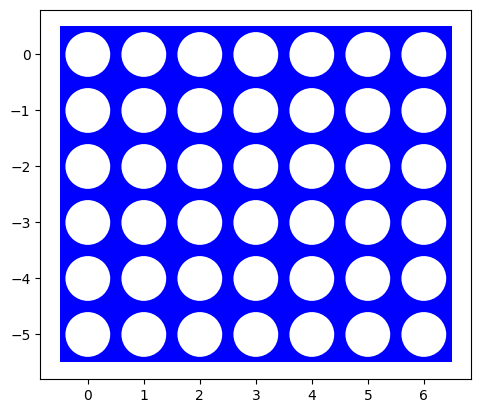

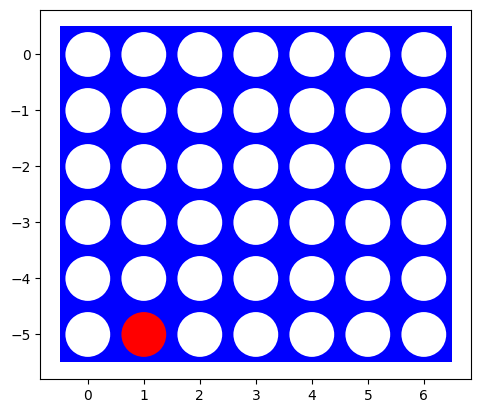

AI chooses 3


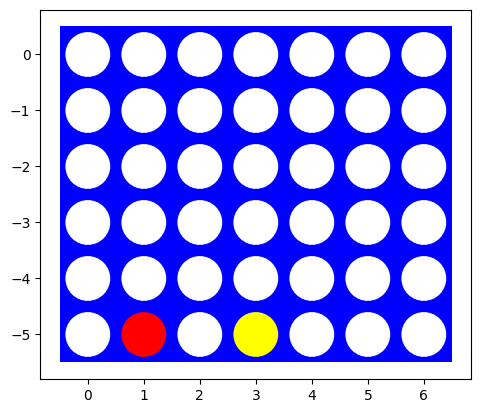

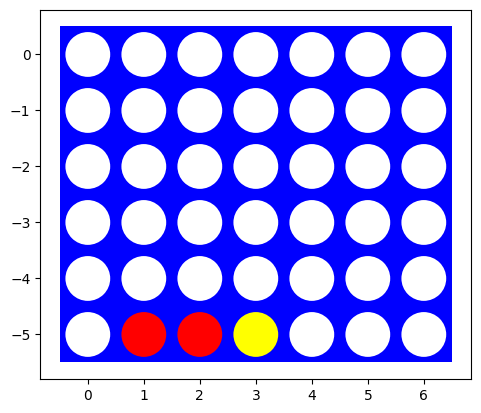

AI chooses 3


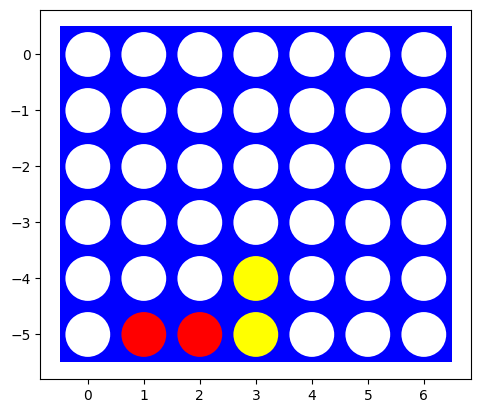

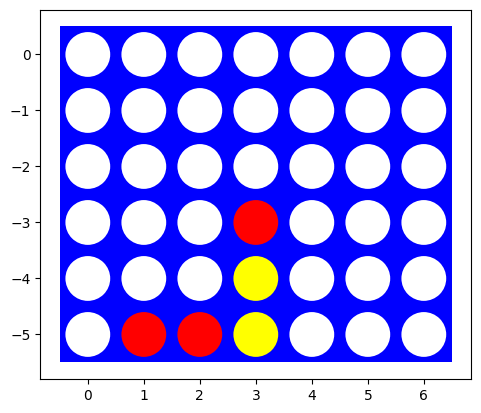

AI chooses 2


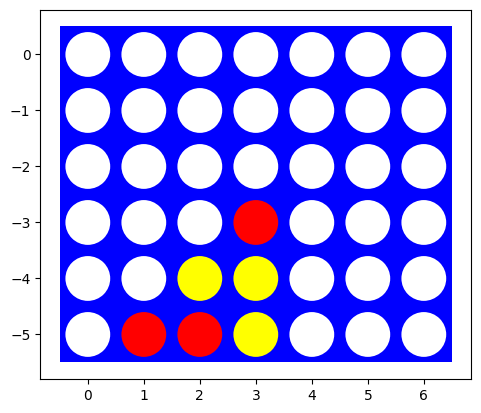

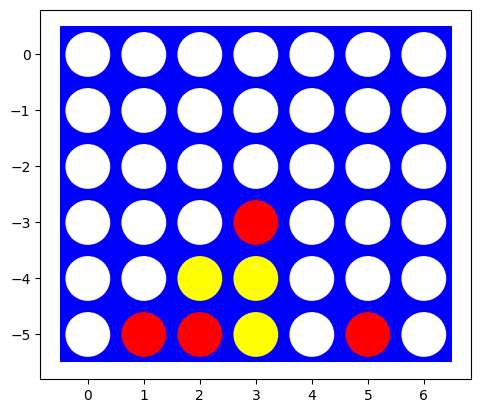

AI chooses 1


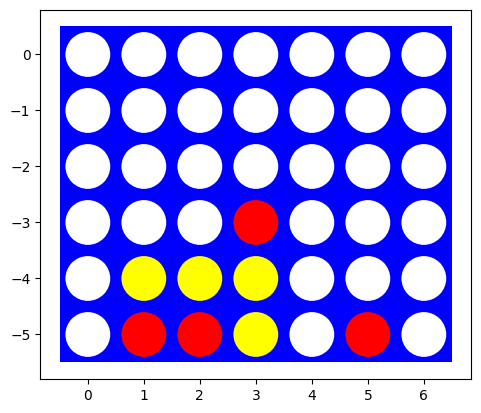

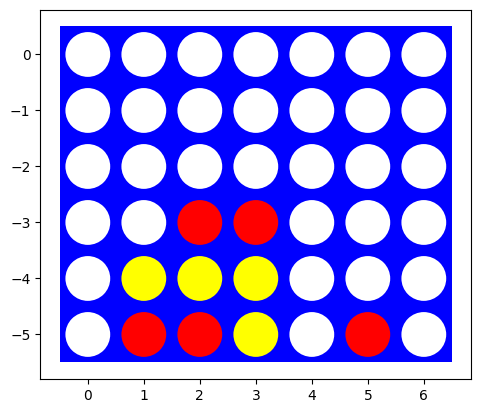

AI chooses 1


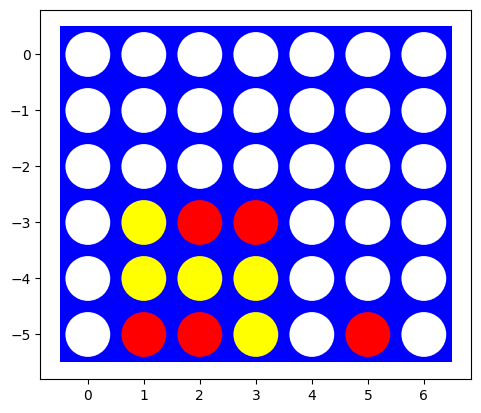

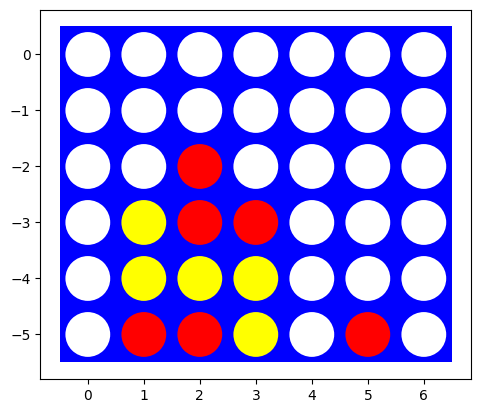

AI chooses 5


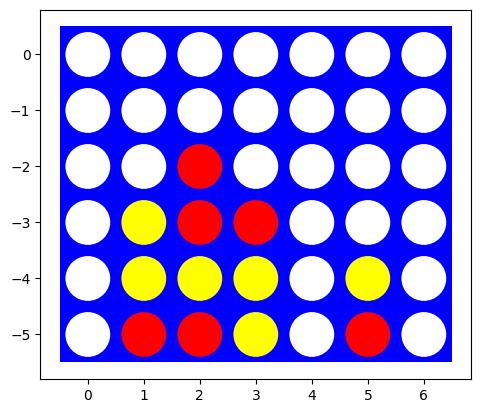

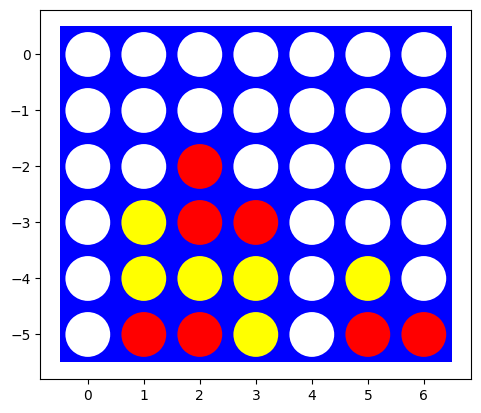

AI chooses 1


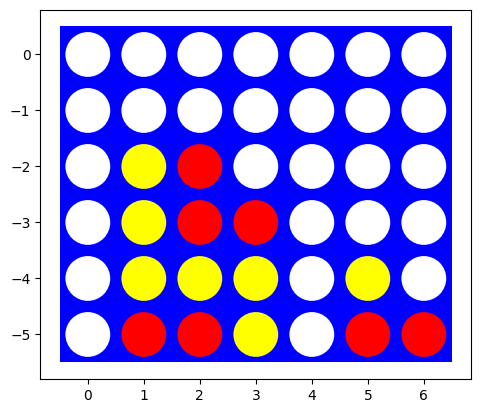

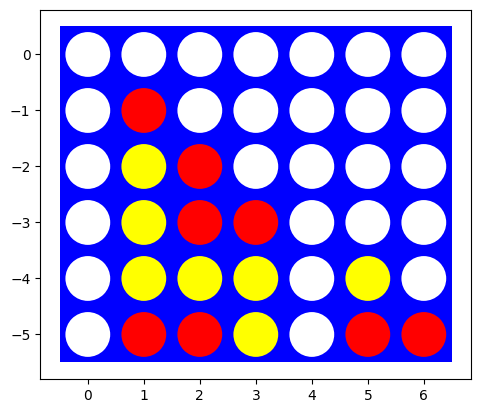

AI chooses 6


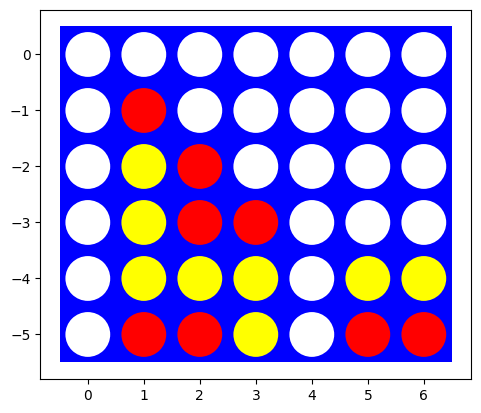

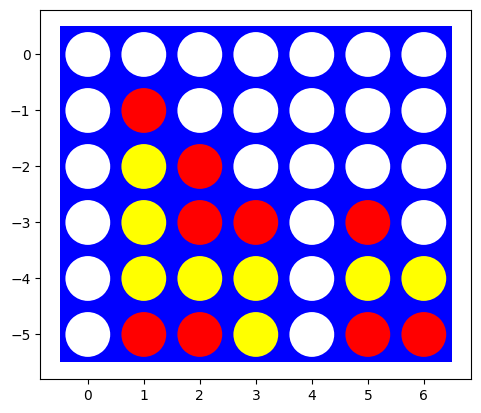

AI chooses 6


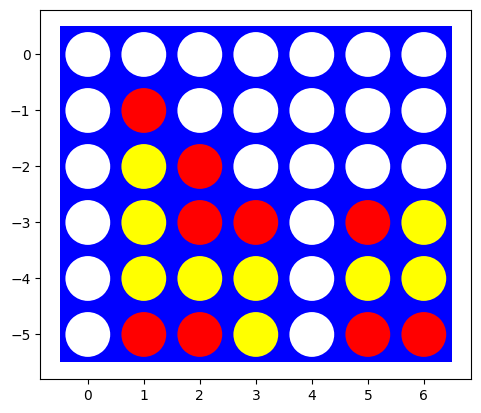

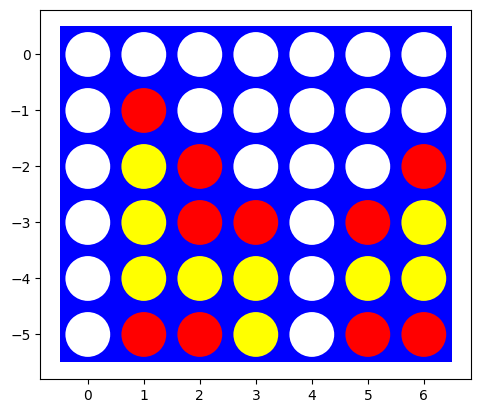

AI chooses 2


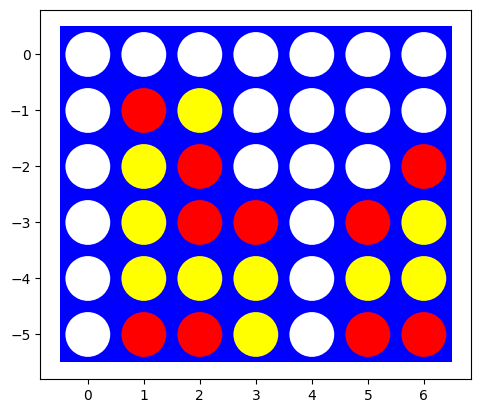

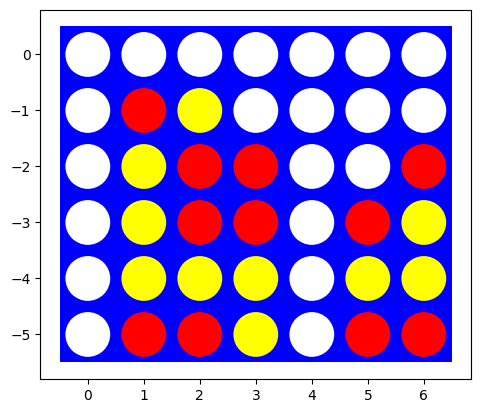

AI chooses 5


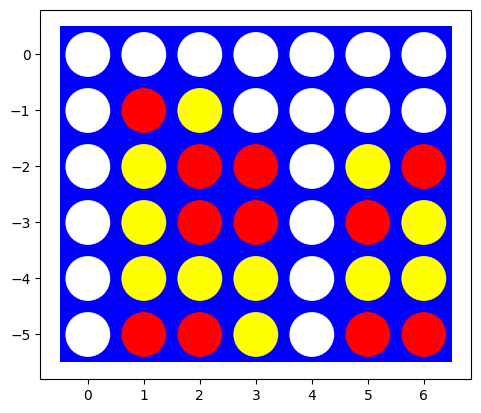

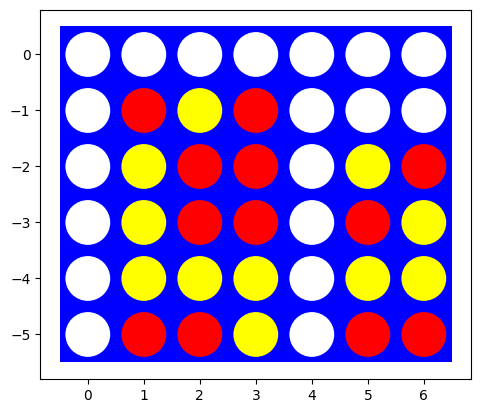

AI chooses 3


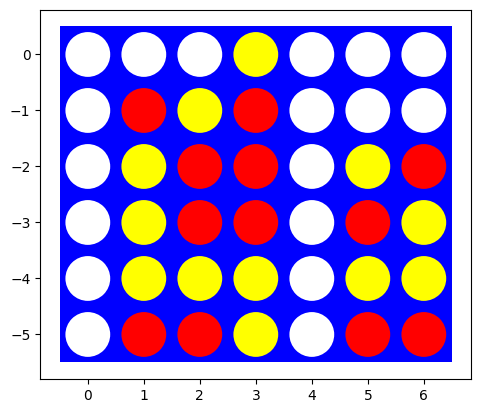

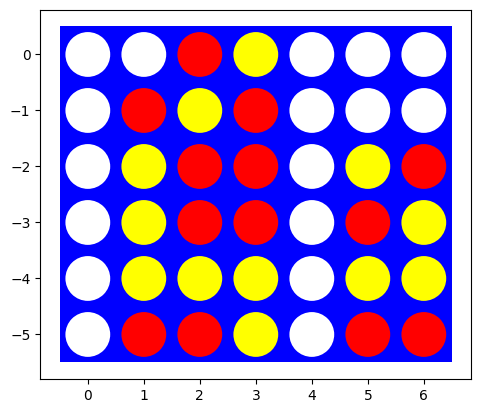

AI chooses 6


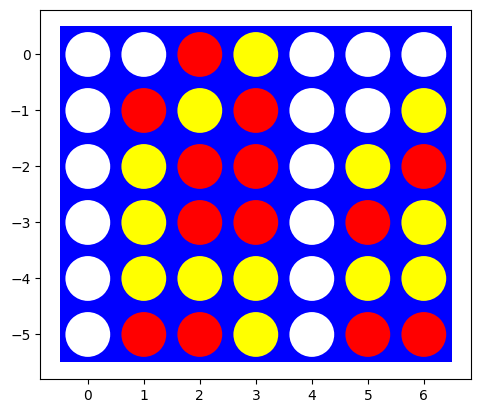

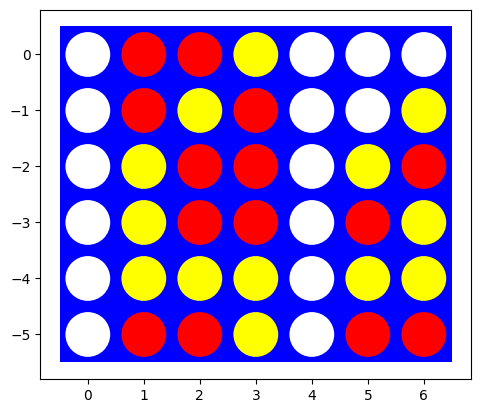

AI chooses 6


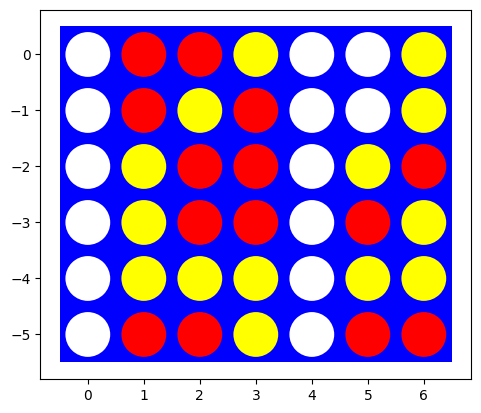

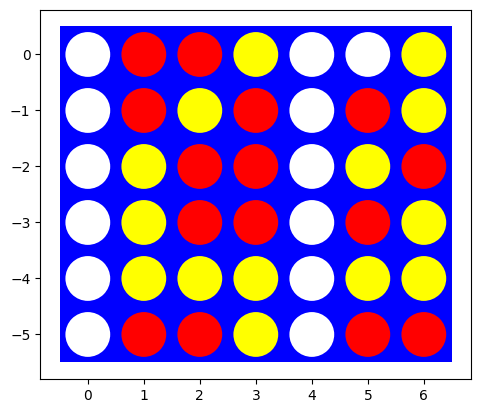

AI chooses 0


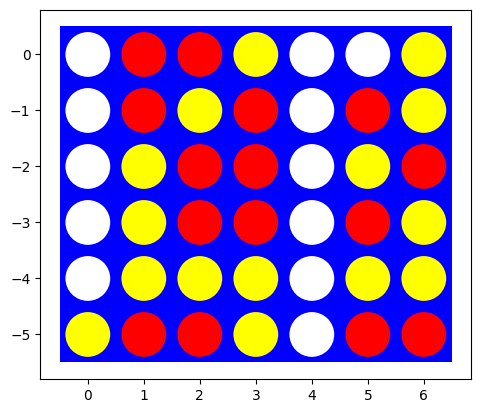

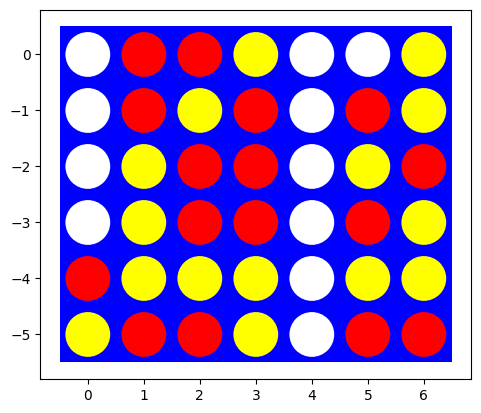

AI chooses 0


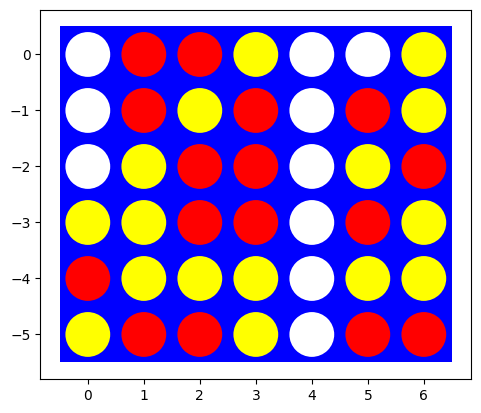

BOT wins


In [21]:
if __name__ == "__main__":
    board, cols = init_state()
    visualize(board)  # In bảng ban đầu

    while True:
        if terminal(board, cols):
            w = get_winner_exact(board)
            if w == PLAYER:
                print("PLAYER wins")
            elif w == BOT:
                print("BOT wins")
            else:
                print("Draw")
            break

        if player(board) == PLAYER:
            while True:
                try:
                    c = int(input("Your move (0-6): "))
                    if c not in actions(cols):
                        print("Invalid/Full column")
                        continue
                    board, cols = result(board, cols, c)
                    visualize(board)  # In bảng sau khi người chơi đánh
                    break
                except ValueError:
                    print("Enter integer 0-6")
        else:
            # AI move
            move = alphabeta_decision(board, cols, depth=5)  # tune depth
            if move is None:
                move = random.choice(actions(cols))
            print("AI chooses", move)
            board, cols = result(board, cols, move)
            visualize(board)  # In bảng sau khi AI đánh